In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds

IMAGE_DIR = r"F:\PROJECTS\tooth-cavity-segmentation\data\train"
MASK_DIR = r'F:\PROJECTS\tooth-cavity-segmentation\data\train_mask'
TEST_IMAGE_DIR = r"F:\PROJECTS\tooth-cavity-segmentation\data\test"
TEST_MASK_DIR = r'F:\PROJECTS\tooth-cavity-segmentation\data\test_mask'

image_files = sorted([f for f in os.listdir(IMAGE_DIR) ])
mask_files = sorted([f for f in os.listdir(MASK_DIR) ])
test_image_files = sorted([f for f in os.listdir(TEST_IMAGE_DIR)])
test_mask_files = sorted([f for f in os.listdir(TEST_MASK_DIR) ])


assert image_files == mask_files, "Mismatch between image and mask files."
assert test_image_files == test_mask_files, "Mismatch between image and mask files."



In [2]:
image_paths = [os.path.join(IMAGE_DIR, file) for file in image_files]
mask_paths = [os.path.join(MASK_DIR, file) for file in mask_files]

dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

test_image_paths = [os.path.join(TEST_IMAGE_DIR, file) for file in test_image_files]
test_mask_paths = [os.path.join(TEST_MASK_DIR, file) for file in test_mask_files]

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))


In [3]:
def load_data(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    
    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    return {
        'file_name': image_path,
        'image': image,
        'segmentation_mask': mask,
    }


In [4]:
dataset = dataset.map(lambda img_path, mask_path: load_data(img_path, mask_path))
test_dataset = test_dataset.map(lambda img_path, mask_path: load_data(img_path, mask_path))

In [5]:
for data in dataset.take(1):  # Take the first sample for demonstration
    print(f"File Name: {data['file_name'].numpy().decode()}")
    print(f"Image shape: {data['image'].shape}")
    print(f"Mask shape: {data['segmentation_mask'].shape}")


File Name: F:\PROJECTS\tooth-cavity-segmentation\data\train\200203133457638.jpg
Image shape: (1024, 1280, 3)
Mask shape: (1024, 1280, 1)


In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.clip_by_value(input_mask, 0, 1)
  
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = len(image_files) // BATCH_SIZE
STEPS_PER_EPOCH

8

In [9]:
train_images = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))
test_batches = test_images.batch(BATCH_SIZE)

In [12]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

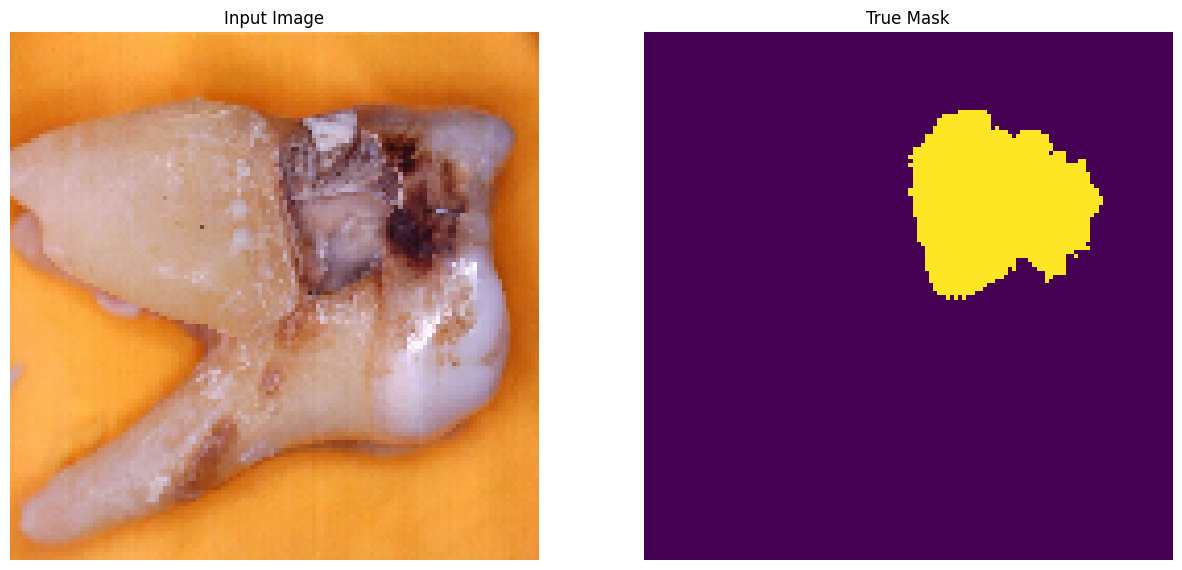

In [13]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])


  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 687ms/step


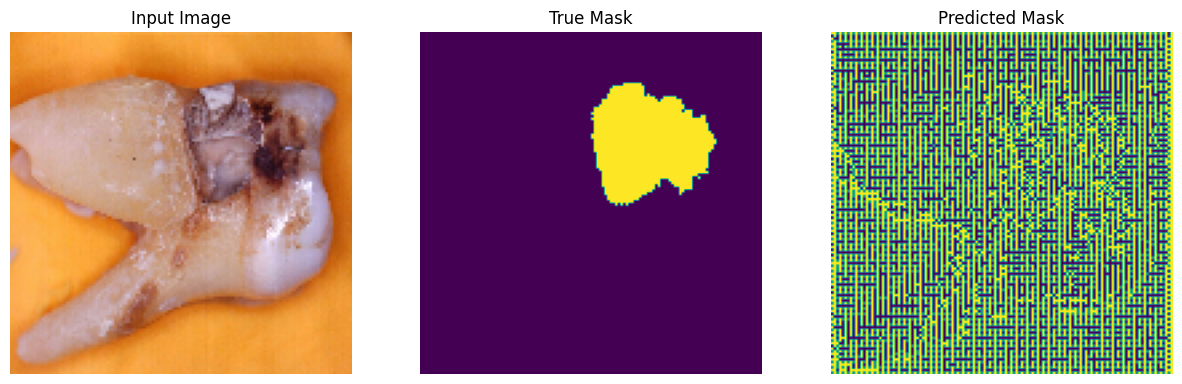

In [20]:
show_predictions()

In [21]:
from IPython.display import clear_output

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 33ms/step


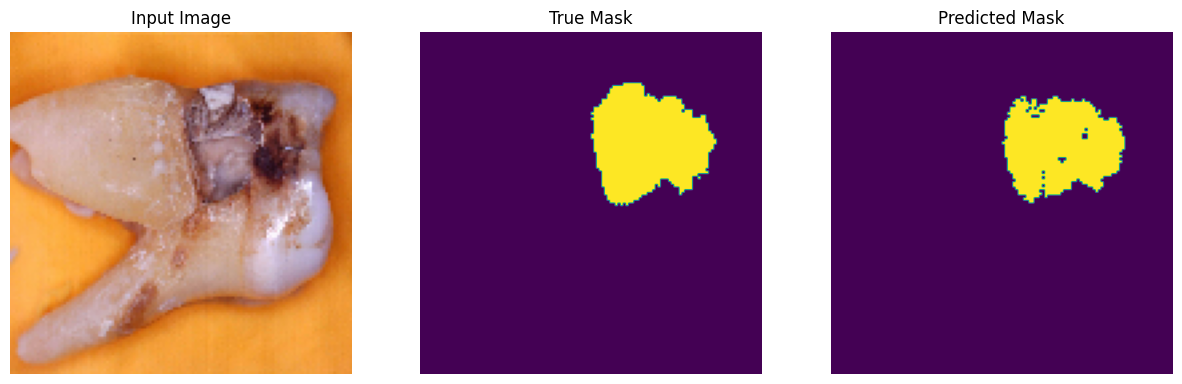


Sample Prediction after epoch 25

8/8 [==============================] - 9s 1s/step - loss: 0.0233 - accuracy: 0.9914


In [25]:
EPOCHS = 25

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[DisplayCallback()])

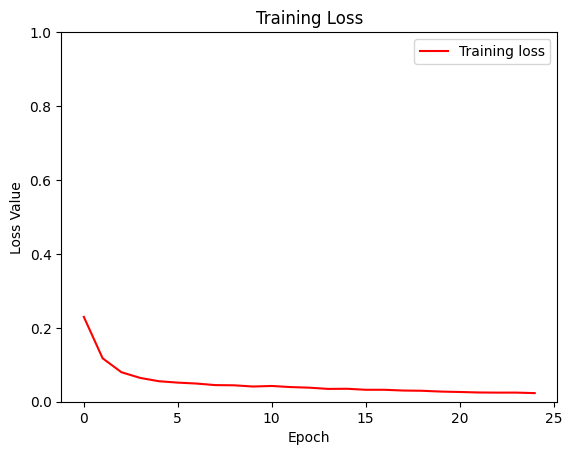

In [28]:
loss = model_history.history['loss']
plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 33ms/step


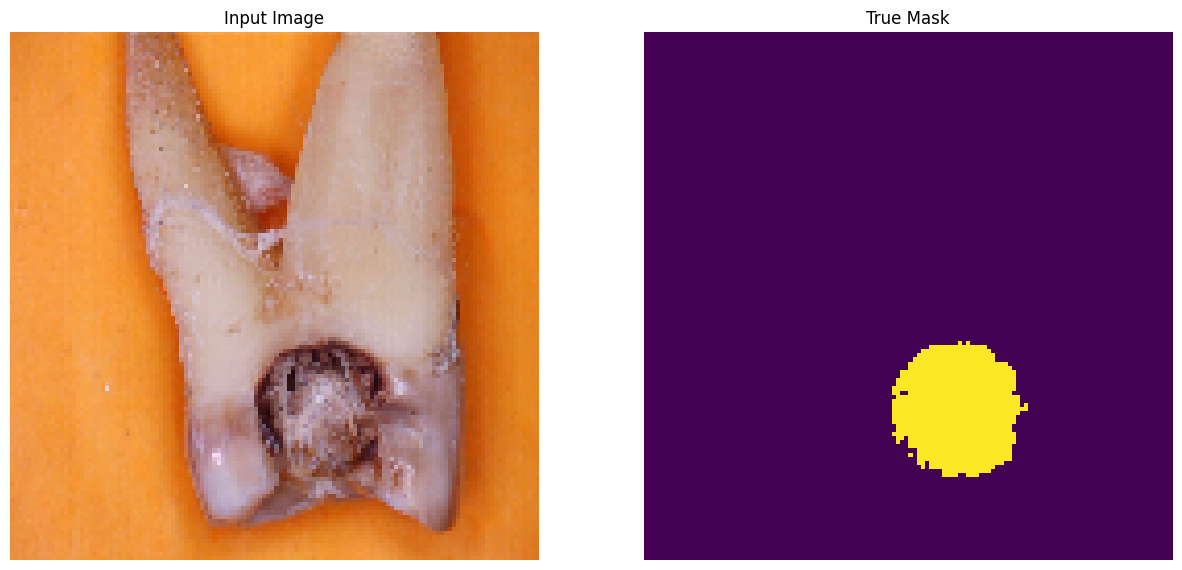

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    image = tf.image.resize(image, (128, 128))

    image = tf.cast(image, tf.float32) / 255.0
    
    return image

def predict_single_image(image_path):

    image = load_and_preprocess_image(image_path)

    image = tf.expand_dims(image, axis=0)

    pred_mask = model.predict(image)

    pred_mask = create_mask(pred_mask)

    display([tf.squeeze(image, axis=0), pred_mask])


input_image_path = r"F:\PROJECTS\tooth-cavity-segmentation\data\test\200203133545216.jpg"
predict_single_image(input_image_path)
